In [49]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

base_path = "iam-handwriting-word-database"
words_list = []

words = open(f"{base_path}/words_new.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

split_idx = int(0.7 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")
print(f"Total: {len(train_samples) + len(validation_samples) + len(test_samples)}")

base_image_path = os.path.join(base_path, "iam_words/words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

print(char_to_num.get_vocabulary())

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

"""
def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image
"""

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [image_height, image_width])
    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
    image /= 255.0  # Normalize to [0,1]
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label} #image, label #{"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

Total training samples: 26813
Total validation samples: 5746
Total test samples: 5746
Total: 38305
Maximum length:  19
Vocab size:  76
['[UNK]', '!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [50]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])
    
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i], verbose=0)
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f" Mean edit distance: {np.mean(edit_distances):.4f}"
        )

In [103]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import tensorflow.keras

input_img = keras.Input(shape=(image_height, image_width, 3), name="image")
labels = keras.layers.Input(name="label", shape=(None,))

resnet = ResNet50(include_top=False, weights='imagenet', input_tensor=input_img) #, input_shape=(image_height, image_width, 3))
output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)

output = keras.layers.Reshape((-1, image_width))(output)

output = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense_last")(output)

# Add the CTC layer
labels = keras.layers.Input(name="label", shape=(None,))
output = CTCLayer(name="ctc_loss")(labels, output)

resnet = Model([resnet.input, labels], outputs=output)

for layer in resnet.layers:
    layer.trainable = True
resnet.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 32, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 134, 3)   0           ['image[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 64, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 8, 32, 64)    36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 8, 32, 64)   256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 8, 32, 64)   0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 8, 32, 256)   16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 4, 16, 128)   147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 4, 16, 128)  512         ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 4, 16, 128)  0           ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 4, 16, 512)   66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 2, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 2, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 2, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 2, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 2, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 2, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 2, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 2, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 1, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 1, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 1, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 1, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

In [104]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
#model = Sequential()
#model.add(resnet)
#model.add(Dense(512, activation='relu', input_dim=(image_height, image_width, 3)))
#model.add(Dropout(0.3))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax"))
resnet.compile(optimizer=keras.optimizers.Adam())
#resnet.summary()

prediction_model = keras.models.Model(
    resnet.get_layer(name="image").input, resnet.get_layer(name="dense_last").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

def data_generator(dataset):
    for data in dataset.take(1):
        images, labels = data["image"], data["label"]
    
    return images, labels

# Create the generator
train_imgs, train_labels = data_generator(train_ds)
val_imgs, val_labels = data_generator(validation_ds)

history = resnet.fit(
    train_ds,
    validation_data=validation_ds,
    #[train_imgs, train_labels],
    #validation_data=[val_imgs, val_labels],
    epochs=10,
    callbacks=[edit_distance_callback, early_stopping],
    verbose=1
)

Epoch 1/10
419/419 [==============================] - 79s 175ms/step - loss: 19.1526 - val_loss: 21.2531
Epoch 2/10
419/419 [==============================] - 70s 167ms/step - loss: 7.7591 - val_loss: 10.2215
Epoch 3/10
419/419 [==============================] - 72s 172ms/step - loss: 5.4964 - val_loss: 6.1456
Epoch 4/10
419/419 [==============================] - 69s 166ms/step - loss: 4.1687 - val_loss: 6.3012
Epoch 5/10
419/419 [==============================] - 71s 169ms/step - loss: 3.3400 - val_loss: 6.3371
Epoch 6/10
419/419 [==============================] - 74s 177ms/step - loss: 2.7582 - val_loss: 5.8838
Epoch 7/10
419/419 [==============================] - 71s 170ms/step - loss: 2.3149 - val_loss: 6.3617
Epoch 8/10
419/419 [==============================] - 70s 167ms/step - loss: 1.9486 - val_loss: 7.6115
Epoch 9/10
419/419 [==============================] - 70s 168ms/step - loss: 1.6290 - val_loss: 6.5918


2/2 [==============================] - 0s 181ms/step


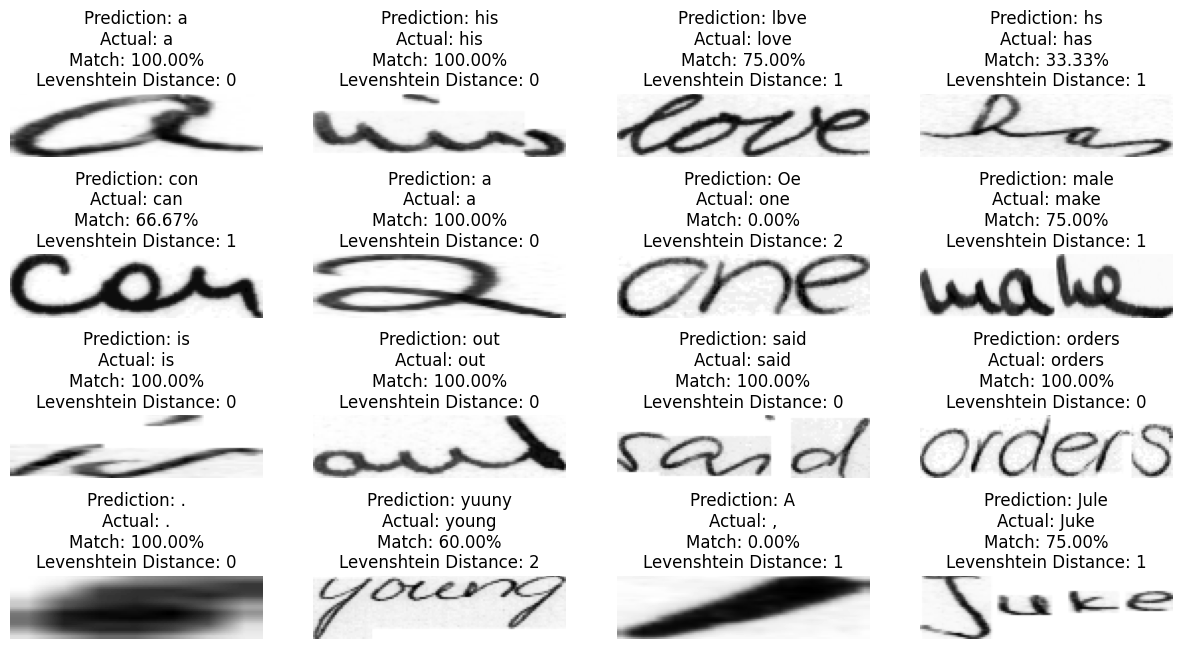

In [112]:
def calculate_match_percentage(actual, predicted):
    if len(actual) == 0:
        return 0.0
    match = sum([1 for a, b in zip(actual, predicted) if a == b])
    return match / len(actual)

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    for i in range(16):
        img = batch_images[i]
        #img = tf.image.flip_left_right(img)
        #img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token
        batch_label = batch_labels[i]
        indices = tf.gather(batch_label, tf.where(tf.math.not_equal(batch_label, padding_token)))
        # Convert to string.
        batch_label = tf.strings.reduce_join(num_to_char(indices))
        batch_label = batch_label.numpy().decode("utf-8")
        
        title = f"Prediction: {pred_texts[i]}\nActual: {batch_label}\nMatch: {calculate_match_percentage(batch_label, pred_texts[i]) * 100:.2f}%\nLevenshtein Distance: {levenshtein_distance(batch_label, pred_texts[i])}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [72]:
from tensorflow.keras.applications import ResNet50

def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_height, image_width, 3), name="image")  # ResNet50 requires 3 channels
    labels = keras.layers.Input(name="label", shape=(None,))

    # Load ResNet50 model, pretrained on ImageNet
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)

    # Make the ResNet50 layers non-trainable
    for layer in resnet_model.layers:
        layer.trainable = False

    # Flatten the output of the ResNet50 model
    x = keras.layers.Flatten()(resnet_model.output)

    # Dense layer
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    #x = tf.expand_dims(x, axis=1)
    
    # RNNs
    x = keras.layers.Reshape((-1, 128))(x)

    # +2 is to account for the two special tokens introduced by the CTC loss
    x = keras.layers.TimeDistributed(keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    ))(x)
    
    

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )

    # Optimizer
    opt = keras.optimizers.Adam()

    # Compile the model and return
    model.compile(optimizer=opt)
    return model

model = build_model()
model.summary()

ValueError: Exception encountered when calling layer "reshape_2" (type Reshape).

total size of new array must be unchanged, input_shape = [64], output_shape = [-1, 128]

Call arguments received by layer "reshape_2" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 64), dtype=float32)

In [ ]:
model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10,
    callbacks=[edit_distance_callback, early_stopping],
    verbose=1
)

In [51]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # Define the base ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False)
    
    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Add a fully-connected layer
    #x = Dense(1024, activation='relu')(x)
    
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)
    
    # Add a logistic layer with the number of classes equal to the vocabulary size
    #predictions = Dense(len(char_to_num.get_vocabulary())-1, activation='softmax')(x)
    
    #num_classes = len(np.unique(labels))  # replace 'labels' with your labels
    predictions = Dense(max_len, activation='softmax')(x)

    output = CTCLayer(name="ctc_loss")(labels, predictions)
    
    # Define the model we will train
    #model = Model(inputs=base_model.input, outputs=predictions)
    
    """
    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)
    """
    
    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

ValueError: Exception encountered when calling layer "ctc_loss" (type CTCLayer).

in user code:

    File "C:\Users\shc\AppData\Local\Temp\ipykernel_17116\2384520182.py", line 13, in call  *
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    File "C:\Users\shc\miniconda3\envs\tfenv\lib\site-packages\keras\backend.py", line 7016, in ctc_batch_cost
        tf.compat.v1.transpose(y_pred, perm=[1, 0, 2]) + epsilon()

    ValueError: Dimension must be 2 but is 3 for '{{node ctc_loss/transpose_2}} = Transpose[T=DT_FLOAT, Tperm=DT_INT32](Placeholder_1, ctc_loss/transpose_2/perm)' with input shapes: [?,19], [3].


Call arguments received by layer "ctc_loss" (type CTCLayer):
  • y_true=tf.Tensor(shape=(None, None), dtype=float32)
  • y_pred=tf.Tensor(shape=(None, 19), dtype=float32)

In [ ]:
model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

In [47]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

epochs = 10

# Define the base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer with the number of classes equal to the vocabulary size
#predictions = Dense(len(char_to_num.get_vocabulary())-1, activation='softmax')(x)

#num_classes = len(np.unique(labels))  # replace 'labels' with your labels
predictions = Dense(max_len, activation='softmax')(x)

# Define the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First, we will only train the top layers (which were randomly initialized)
# i.e. freeze all convolutional ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# Train the model on the new data for a few epochs
#model.fit(train_ds, epochs=10, validation_data=validation_ds)
history1 = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    verbose=1
)

# At this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from ResNet50. We will freeze the bottom N layers
# and train the remaining top layers.

# Let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# We chose to train the top 2 ResNet blocks, i.e. we will freeze
# the first 165 layers and unfreeze the rest:
for layer in model.layers[:165]:
   layer.trainable = False
for layer in model.layers[165:]:
   layer.trainable = True

# We need to recompile the model for these modifications to take effect
# We use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# We train our model again (this time fine-tuning the top 2 ResNet blocks
# alongside the top Dense layers
#model.fit(train_ds, epochs=10, validation_data=validation_ds)
history2 = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\shc\miniconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\shc\miniconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\shc\miniconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\shc\miniconda3\envs\tfenv\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\shc\miniconda3\envs\tfenv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\shc\miniconda3\envs\tfenv\lib\site-packages\keras\engine\input_spec.py", line 197, in assert_input_compatibility
        raise ValueError(

    ValueError: Missing data for input "input_11". You passed a data dictionary with keys ['image', 'label']. Expected the following keys: ['input_11']


In [48]:
def preprocess_and_predict(image_path):
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Add an extra dimension for the batch size
    image = tf.expand_dims(image, axis=0)
    
    # Make prediction
    prediction = model.predict(image)
    
    # Convert prediction to character
    predicted_sequence = tf.math.argmax(prediction[0], axis=-1)
    predicted_string = num_to_char(predicted_sequence)
    
    return predicted_string.numpy().decode("utf-8")

2/2 [==============================] - 2s 11ms/step


InvalidArgumentError: {{function_node __wrapped__Transpose_device_/job:localhost/replica:0/task:0/device:GPU:0}} transpose expects a vector of size 2. But input(1) is a vector of size 3 [Op:Transpose]

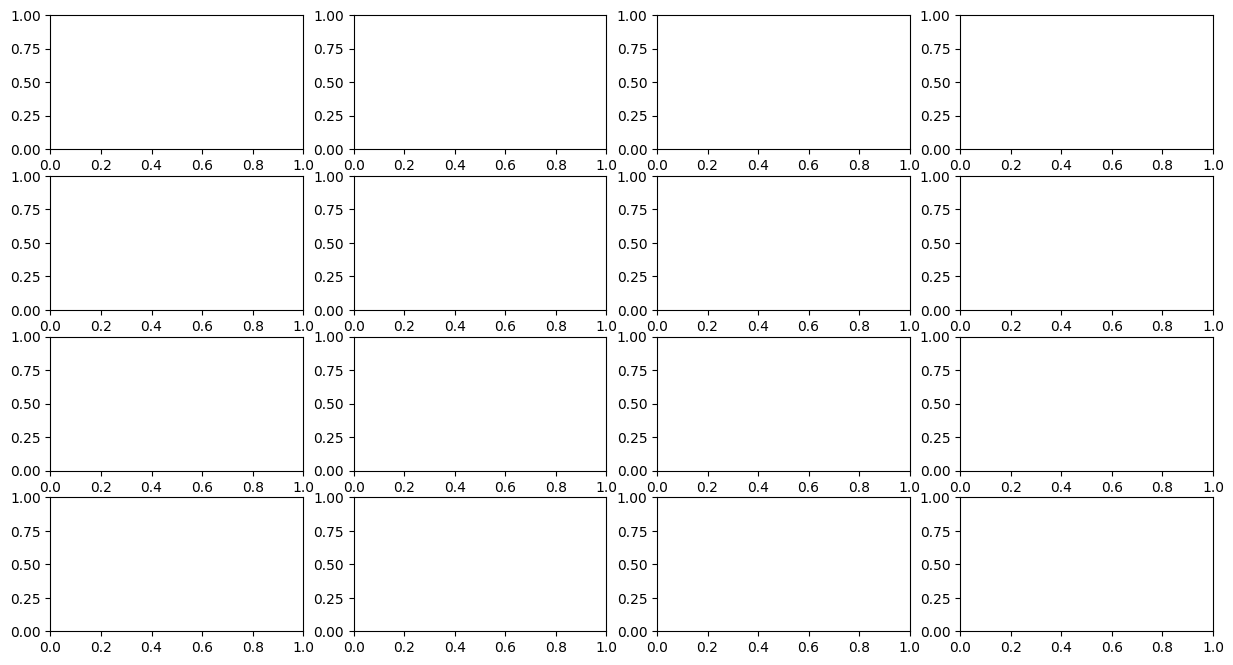

In [45]:
def calculate_match_percentage(actual, predicted):
    if len(actual) == 0:
        return 0.0
    match = sum([1 for a, b in zip(actual, predicted) if a == b])
    return match / len(actual)

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token
        batch_label = batch_labels[i]
        indices = tf.gather(batch_label, tf.where(tf.math.not_equal(batch_label, padding_token)))
        # Convert to string.
        batch_label = tf.strings.reduce_join(num_to_char(indices))
        batch_label = batch_label.numpy().decode("utf-8")
        
        title = f"Prediction: {pred_texts[i]}\nActual: {batch_label}\n{calculate_match_percentage(batch_label, pred_texts[i]) * 100:.2f}% match"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [5]:
import numpy as np
import cv2

def draw_bounding_boxes(image, num_boxes, box_height):
    bounding_boxes = []
    start_x = 0  # Starting x coordinate for the first box
    start_y = 10  # Starting y coordinate for the boxes

    total_width = image.shape[1]  # Get the width of the image
    box_width = total_width // num_boxes  # Calculate the width of each box

    for i in range(num_boxes):
        # Generate a random color
        color = tuple(np.random.randint(0, 256, 3).tolist())

        # Draw bounding box with fixed height and width on the original image
        cv2.rectangle(image, (start_x + i * box_width, start_y), (start_x + (i + 1) * box_width, start_y + box_height), color, 2)

        bounding_boxes.append((start_x + i * box_width, start_y, box_width, box_height))

    # Return the bounding boxes and the image
    return bounding_boxes, image

In [18]:
import cv2
import numpy as np

def extract_features(image, bounding_boxes):
    all_features = []
    for box in bounding_boxes:
        x, y, w, h = box

        # Extract the region of interest based on the bounding box
        roi = image[y:y+h, x:x+w]

        # Convert the image to grayscale if it's not already
        if len(roi.shape) == 3:
            roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

        # Ensure the image is in the correct format
        roi = (roi * 255).astype(np.uint8)

        # Compute SIFT features for the region of interest
        _, features = sift.detectAndCompute(roi, None)

        # Add the features to the list of all features
        if features is not None:
            all_features.extend(features)
    return all_features

In [23]:
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
import cv2

# Assume that 'train_ds' is your training dataset
# and 'draw_bounding_boxes' is the function that draws bounding boxes and returns them

# Initialize SIFT feature extractor
sift = cv2.xfeatures2d.SIFT_create()

all_features = []
all_labels = []

for data in train_ds.take(1):
    images, labels = data["image"], data["label"]
    
    for i in range(16):
        image = images[i].numpy()
        label = labels[i].numpy()
        
        image = images[i]
        image = tf.image.flip_left_right(image)
        image = tf.transpose(image, perm=[1, 0, 2])
        image = (image * 255.0).numpy().clip(0, 255).astype(np.uint8)
        image = image[:, :, 0]

        # Draw bounding boxes on the image
        bounding_boxes, _ = draw_bounding_boxes(image, num_boxes=len(label), box_height=image.shape[0])

        # Extract features from the bounding boxes
        features = extract_features(image, bounding_boxes)

        all_features.extend(features)
        all_labels.append(label)

# Now you can use 'all_features' and 'all_labels' to train your Bag of Words model

In [24]:
# Step 2: Cluster the features
kmeans = KMeans(n_clusters=len(char_to_num.get_vocabulary())-1)  # Except UNK # The number of clusters is the size of your vocabulary
kmeans.fit(all_features)

KMeans(n_clusters=76)

In [27]:
image_features = []
for features in all_features:
    histogram = np.zeros(100)
    
    # Reshape the features array to 2D if it's a list of 1D arrays
    if isinstance(features[0], np.ndarray):
        features = np.vstack(features)
    
    clusters = kmeans.predict(features)
    for i in clusters:
        histogram[i] += 1
    image_features.append(histogram)

ValueError: Expected 2D array, got 1D array instead:
array=[  0.   0.   0.   0.  28.   3.   0.   0. 105.  10.   0.   0. 173.  29.
   0.   0. 173.  37.   0.   0.  21.   2.   0.   0.  13.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  19.   4.   0.   0.  91.   6.
   0.   0. 173. 100.  14.  18. 173.  28.   0.   0.  29.  15.  11.  52.
  26.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   3.   6.
   1.   0.  12.   0.   0.   0.  58. 173. 120.  38. 114.   1.   0.   0.
   4.  34. 101. 168.  10.   0.   0.   0.   0.   0.   0.   7.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  14.   8.   1.
   0.   0.   0.   0.   0.   2.   8.   6.   0.   0.   0.   0.   0.   0.
   0.   0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [21]:
# Step 4: Use these histograms as feature vectors to train a classifier

svm = LinearSVC()
svm.fit(image_features, labels)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearSVC.